오토인코더 예제 변형 (축소된 3d차원을 2d로 사영시킨 후 2d로 차원을 축소한 것과 비교하기)

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import numpy as np

In [3]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda"if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [4]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [7]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [8]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded,decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


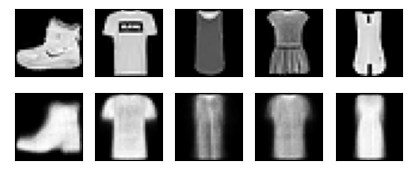

[Epoch 2]


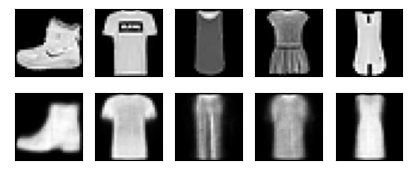

[Epoch 3]


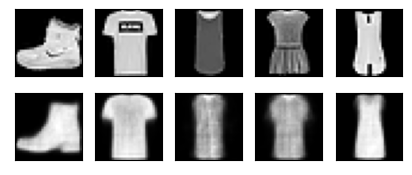

[Epoch 4]


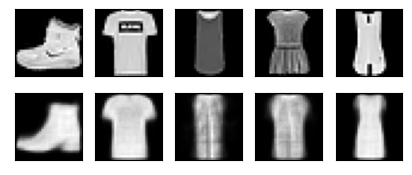

[Epoch 5]


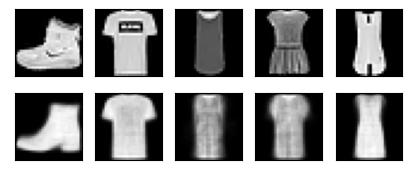

[Epoch 6]


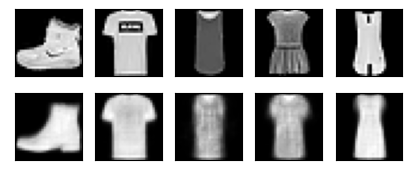

[Epoch 7]


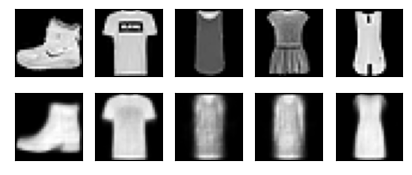

[Epoch 8]


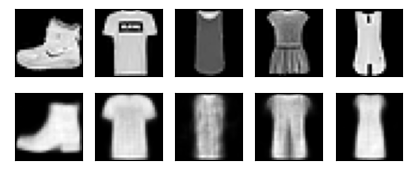

[Epoch 9]


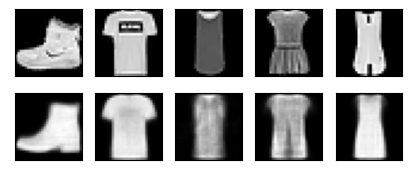

[Epoch 10]


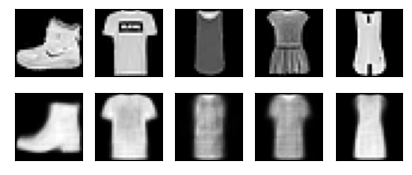

In [9]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _,decoded_data = autoencoder(test_x)

    f,a = plt.subplots(2, 5, figsize=(5,2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i],(28,28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [10]:
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

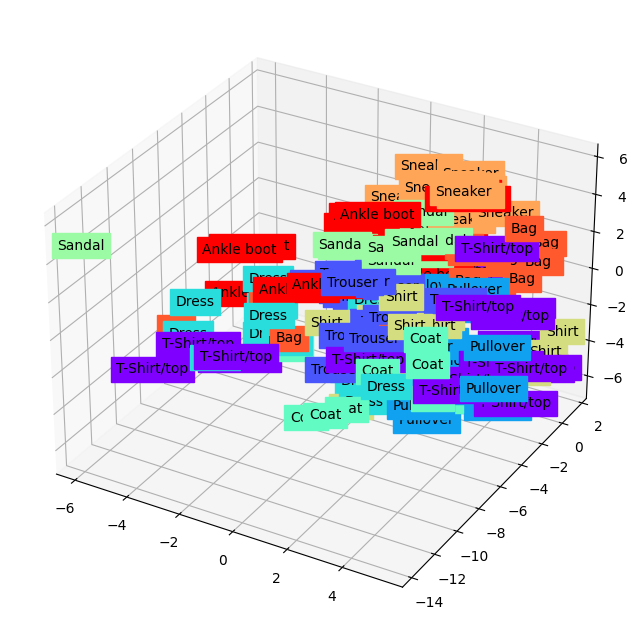

In [11]:
CLASSES = {
    0: 'T-Shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

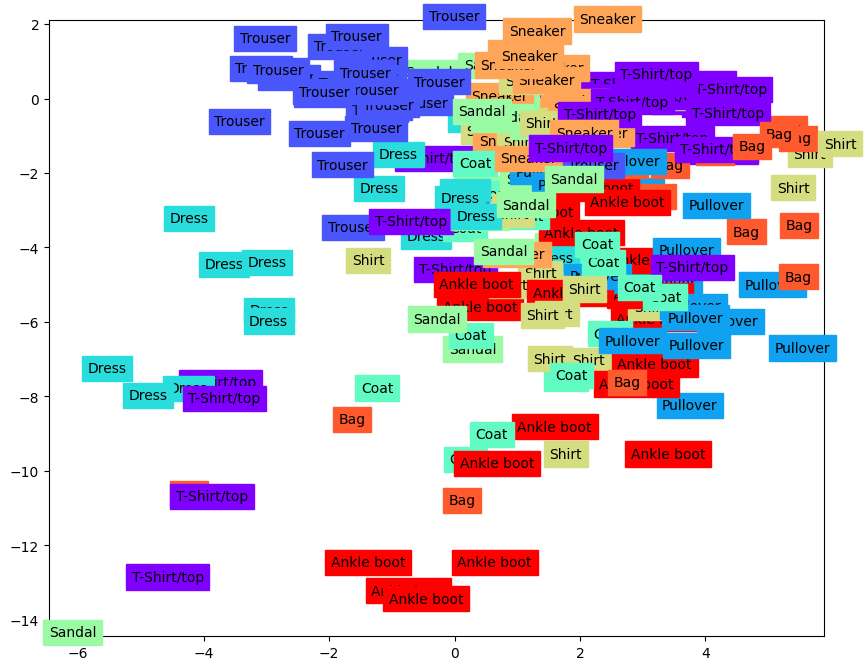

In [17]:
CLASSES = {
    0: 'T-Shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()

labels = trainset.targets[:200].numpy()

for x, y, s in zip(X, Y, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())

plt.show()

In [12]:
def add_noise(img):
    noise = torch.randn(img.size())*0.2

    noisy_img = img + noise
    return noisy_img

In [20]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [18]:
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x =  autoencoder(noisy_x)

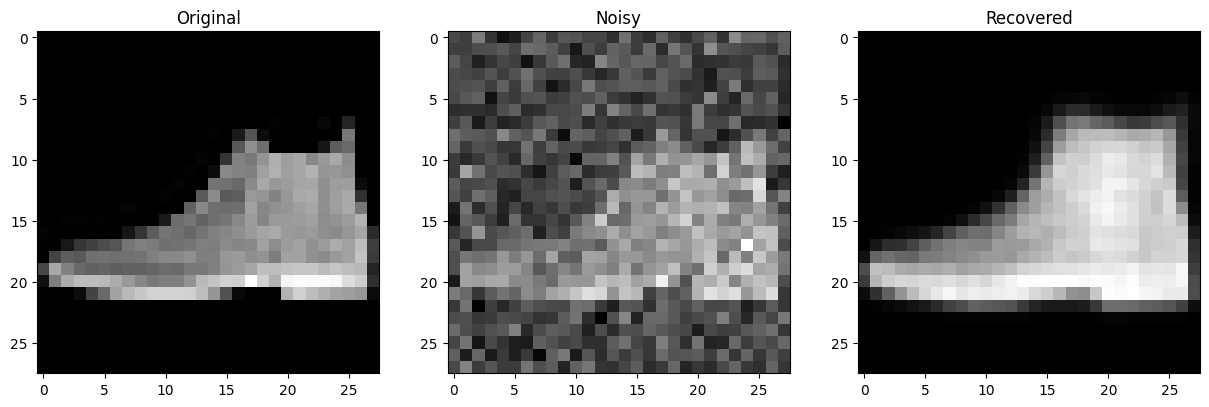

In [19]:
f, a = plt.subplots(1, 3, figsize=(15,15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28,28))
noisy_img =  np.reshape(noisy_x.to("cpu").data.numpy(), (28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28,28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()